# Access InfluxDB from Python

In [54]:
from influxdb import InfluxDBClient
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

In [62]:
# InfluxDB host address and user credentials
host = "192.168.178.63"
username = "influx_user_1"

# This ipython widget input for the password avoids storing the password into the notebook.
display(widgets.Label(f'Enter password for {username=}:'))
pw = widgets.Password(value="password")
display(pw)

Label(value="Enter password for username='influx_user_1':")

Password()

## Make the client and connect to a database

In [48]:
client = InfluxDBClient(host=host, port=8086, username=username, password=pw.value)
client.get_list_database()

[{'name': '_internal'},
 {'name': 'influx_db_1'},
 {'name': 'influx_db_2'},
 {'name': 'influx_db_3'},
 {'name': 'influx_db_4'}]

In [49]:
client.switch_database('influx_db_3')

## Query data 

In [66]:
qstr = 'SELECT * FROM W WHERE TIME >= now() -1m'
df = pd.DataFrame.from_records(client.query(qstr).get_points())
df

,time,current,domain,entity_id,entity_id_str,value,voltage
0,2023-06-25T19:42:28.432365Z,None,sensor,sma_battery_power_discharge_total,None,380.00,None
1,2023-06-25T19:42:28.432687Z,None,sensor,sma_grid_power,None,380.00,None
2,2023-06-25T19:42:28.433095Z,None,sensor,sma_pv_power_b,None,2.00,None
3,2023-06-25T19:42:28.433327Z,None,sensor,sma_metering_power_absorbed,None,3.00,None
4,2023-06-25T19:42:28.434131Z,None,sensor,sma_metering_active_power_draw_l2,None,184.00,None
...,...,...,...,...,...,...,...
145,2023-06-25T19:43:23.309565Z,None,sensor,power_imported,None,4.00,None
146,2023-06-25T19:43:23.310322Z,None,sensor,total_power_consumed,None,384.00,None
147,2023-06-25T19:43:23.314052Z,None,sensor,home_power_consumed,None,384.00,None
148,2023-06-25T19:43:23.315806Z,None,sensor,available_charging_power,None,4616.00,None


In [69]:
df.time = pd.to_datetime(df.time)
df = df.set_index("time")
df.head()

,current,domain,entity_id,entity_id_str,value,voltage
time,,,,,,
2023-06-25 19:42:28.432365+00:00,None,sensor,sma_battery_power_discharge_total,None,380.0,None
2023-06-25 19:42:28.432687+00:00,None,sensor,sma_grid_power,None,380.0,None
2023-06-25 19:42:28.433095+00:00,None,sensor,sma_pv_power_b,None,2.0,None
2023-06-25 19:42:28.433327+00:00,None,sensor,sma_metering_power_absorbed,None,3.0,None
2023-06-25 19:42:28.434131+00:00,None,sensor,sma_metering_active_power_draw_l2,None,184.0,None


In [70]:
df.entity_id.value_counts()

entity_id
sma_metering_power_absorbed                 12
sma_metering_active_power_draw_l2           12
total_power_consumed                        12
power_imported                              12
home_power_consumed                         12
available_charging_power                    12
sma_battery_power_discharge_total           11
sma_metering_active_power_feed_l3           11
filter_filtered_available_charging_power    11
sma_pv_power_b                              10
filter_filtered_power_imported              10
sma_metering_active_power_feed_l1           10
sma_metering_power_supplied                  8
sma_grid_power                               7
Name: count, dtype: int64

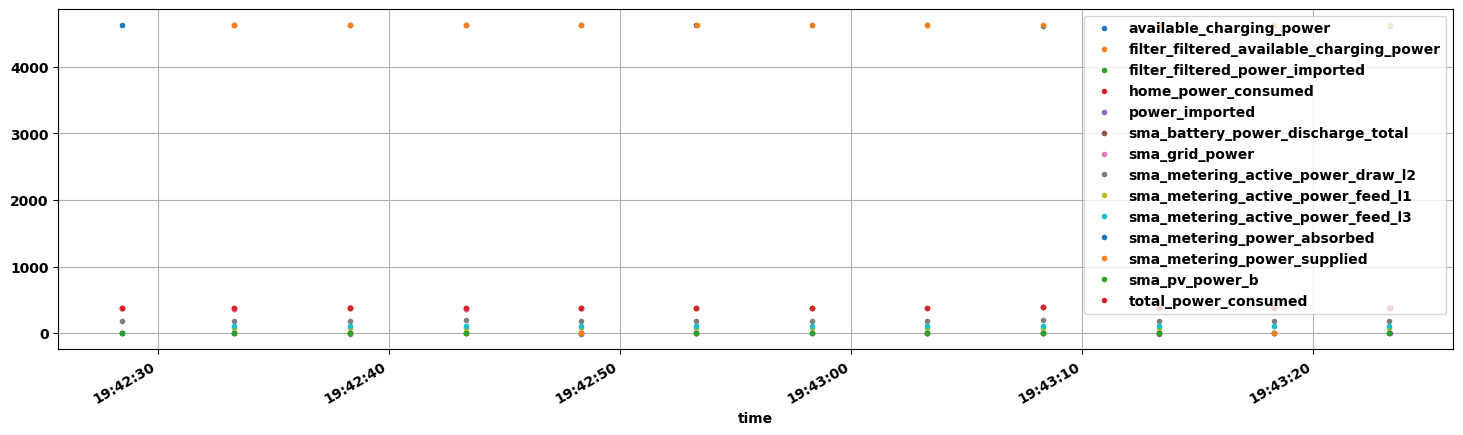

In [80]:
df.groupby('entity_id')['value'].plot(figsize=(18,5), style=".", legend=True, grid="both");